In [1]:
import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm
from sklearn import preprocessing
from scipy.stats import gamma
from numpy.linalg import cholesky, lstsq
import scipy.spatial.distance as spdist

np.random.seed(123)

In [2]:
# Experimental data
data = np.loadtxt('../data/labeled_data.dat')
x_labeled = data[:, :2].astype(np.float64) # -2 because we do not need porosity predictions
y_labeled = data[:, -2:-1].astype(np.float64) # dimensionless bond length and porosity measurements

# normalize dataset with MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
x_labeled = scaler.fit_transform(x_labeled)
# y_labeled = scaler.fit_transform(y_labeled)

# tr_size = int(tr_size)
tr_size = int(5)

# train and test data
trainX, trainY = x_labeled[:tr_size,:], y_labeled[:tr_size]


# Physics data
data_phyloss = np.loadtxt('../data/unlabeled_data_BK_constw_v2_1525.dat')
x_unlabeled = data_phyloss[:, :]
initporo = x_unlabeled[:, -1]

x_unlabeled1 = x_unlabeled[:1303, :2]
x_unlabeled2 = x_unlabeled[-6:, :2]
y_unlabeled1 = data_phyloss[:1303, -2:-1]
y_unlabeled2 = data_phyloss[-6:, -2:-1]

x_unlabeled = np.vstack((x_unlabeled1,x_unlabeled2))
y_unlabeled = np.vstack((y_unlabeled1,y_unlabeled2))

# normalize dataset with MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
x_unlabeled = scaler.fit_transform(x_unlabeled)

# initial porosity
init_poro1 = initporo[:1303]
init_poro2 = initporo[-6:]
init_poro = np.hstack((init_poro1,init_poro2))

In [69]:
# gamma.pdf(0.5, 1, loc=0, scale=1)
np.random.normal(5, 0.06)

5.039081877424317

In [165]:
#The tranistion model defines how to move from sigma_current to sigma_new
# transition_model = lambda x: np.random.normal(x[0], , (1,))
def transition_model(x, scale):
#     return np.random.normal(x[0], scale, (1,))
#     print("tr",x,scale)
    return [np.random.normal(x[0], scale[0]), np.random.normal(x[1], scale[1]), np.random.normal(x[2], scale[2])]

def tune(scale, acc_rate):
    """Tunes the scaling parameter for the proposal
    distribution according to the acceptance rate over the
    last tune_interval:
    
    Rate    Variance adaptation
    ----    -------------------
    <0.001        x 0.1
    <0.05         x 0.5
    <0.2          x 0.9
    >0.5          x 1.1
    >0.75         x 2
    >0.95         x 10
    """
    if acc_rate < 0.001:
        # reduce by 90 percent
        return scale * 0.1
    elif acc_rate < 0.05:
        # reduce by 50 percent
        return scale * 0.5
    elif acc_rate < 0.2:
        # reduce by ten percent
        return scale * 0.9
    elif acc_rate > 0.95:
        # increase by factor of ten
        return scale * 10.0
    elif acc_rate > 0.75:
        # increase by double
        return scale * 2.0
    elif acc_rate > 0.5:
        # increase by ten percent
        return scale * 1.1
    return scale

def prior(ranges, x):
    #x[0] = mu, x[1]=sigma_eps (new or current)
    #returns 1 for all valid values of sigma_eps. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[2] <=0):
        return 0

    lpriors = gamma.pdf(x[0], 1, loc=0, scale=1) * gamma.pdf(x[1], 1, loc=0, scale=1) *\
                     gamma.pdf(x[2], 1, loc=0, scale=1)
    return lpriors

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(theta, trainX, trainY):
    # x[0]=l1, x[1]=l2, x[2]=sigma (new or current)
    # data: observations
    def covSEard(hyp=None, x=None, z=None):
        ''' Squared Exponential covariance function with Automatic Relevance Detemination
         (ARD) distance measure. The covariance function is parameterized as:

         k(x^p,x^q) = sf2 * exp(-(x^p - x^q)' * inv(P) * (x^p - x^q)/2)

         where the P matrix is diagonal with ARD parameters ell_1^2,...,ell_D^2, where
         D is the dimension of the input space and sf2 is the signal variance.
        '''
        [n, D] = x.shape
        ell = 1/np.array(hyp[0:D])        # characteristic length scale
        sf2 = np.array(hyp[D])**2         # signal variance
        tmp = np.dot(np.diag(ell),x.T).T
        A = spdist.cdist(np.dot(np.diag(ell),x.T).T, np.dot(np.diag(ell),z.T).T, 'sqeuclidean') # compute covariance between data sets x and z
        A = sf2*np.exp(-0.5*A)  
        return A
    
    def log_like(X_train, Y_train, theta, sigma_y=0):
        '''  
        Computes the suffifient statistics of the GP posterior predictive distribution 
        from m training data X_train and Y_train and n new inputs X_s.

        Args:
            X_s: New input locations (n x d).
            X_train: Training locations (m x d).
            Y_train: Training targets (m x 1).
            l: Kernel length parameter.
            sigma_f: Kernel vertical variation parameter.
            sigma_y: Noise parameter.

        Returns:
            Posterior mean vector (n x d) and covariance matrix (n x n).
        '''
#         noise = 0
#         K = covSEard(hyp=[theta[0],theta[1],theta[2]], x=X_train, z=X_train) + noise**2 * np.eye(len(X_train))
        K = covSEard(hyp=[theta[0],theta[1],theta[2]], x=X_train, z=X_train)
        K += 1e-8 * np.eye(*K.shape)
        L = cholesky(K)
        loglik =  np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
        return loglik
    return log_like(trainX, trainY, theta)
    
#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
#     print(x, x_new)
    if x_new > x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
#         print("else",accept ,(np.exp(x_new-x)))
        return (accept < (np.exp(x_new-x)))

def sample(x_curr, trainX, trainY, bounds, scale, acc):
    x_new =  transition_model(x_curr, scale)
#     print("curr and new", x_curr, x_new)
    x_lik = manual_log_like_normal(x_curr, trainX, trainY)
    x_new_lik = manual_log_like_normal(x_new, trainX, trainY)
    if (acceptance(x_lik + np.log(prior(bounds, x_curr)), x_new_lik + np.log(prior(bounds, x_new)))):
        x_curr = x_new
        acc += 1
    return x_curr, acc

def metropolis_hastings(param_init, bounds, iter=10):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x, x_new): decides whether to accept or reject the new sample
    samples = []
    acc = 0
    scale = np.array([.1, .1, .2])
    x = param_init
    for i in range(iter):
        print("Iteration: ", i, ", x_" + str(i) + ":", x)
#         x, acc = sample(x, x_unlabeled, y_unlabeled, bounds, scale, acc)
        x, acc = sample(x, trainX, trainY, bounds, scale, acc)
        samples.append(x)
        acc_rate = acc/(i+1)
        if i % 10 == 0:
            scale = tune(scale, acc_rate)
        print("scale:", scale, "acc_rate: ", acc_rate,"\n")
                
    return np.array(samples)

In [166]:
iters = 5000
l1,l2,sigmaf = 0.5, 0.5, 0.5
params = [l1,l2,sigmaf]

# bounds = [l1, l2, sigma_f]
bounds = [5, 5, 5]

samples = metropolis_hastings(params, bounds, iter=iters)

Iteration:  0 , x_0: [0.5, 0.5, 0.5]
scale: [0.01 0.01 0.02] acc_rate:  0.0 

Iteration:  1 , x_1: [0.5, 0.5, 0.5]
scale: [0.01 0.01 0.02] acc_rate:  0.5 

Iteration:  2 , x_2: [0.48929568615081015, 0.5089010451494076, 0.5200471755091053]
scale: [0.01 0.01 0.02] acc_rate:  0.6666666666666666 

Iteration:  3 , x_3: [0.49395115678590146, 0.5170478198061049, 0.5116788437139351]
scale: [0.01 0.01 0.02] acc_rate:  0.75 

Iteration:  4 , x_4: [0.48047307521807586, 0.5324250271157451, 0.5283966066251401]
scale: [0.01 0.01 0.02] acc_rate:  0.8 

Iteration:  5 , x_5: [0.4711402149938411, 0.5283875794736843, 0.5253470895846785]
scale: [0.01 0.01 0.02] acc_rate:  0.8333333333333334 

Iteration:  6 , x_6: [0.48192578864353613, 0.5240200490493907, 0.5042423759005839]
scale: [0.01 0.01 0.02] acc_rate:  0.8571428571428571 

Iteration:  7 , x_7: [0.48067422890051864, 0.5280183870256957, 0.5290174846121645]
scale: [0.01 0.01 0.02] acc_rate:  0.875 

Iteration:  8 , x_8: [0.4790145232757721, 0.532989072

C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:97: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


38 , x_38: [0.14034064907930768, 0.6448511714268309, 1.5700856564844545]
scale: [0.08 0.08 0.16] acc_rate:  0.8205128205128205 

Iteration:  39 , x_39: [0.14034064907930768, 0.6448511714268309, 1.5700856564844545]
scale: [0.08 0.08 0.16] acc_rate:  0.8 

Iteration:  40 , x_40: [0.14034064907930768, 0.6448511714268309, 1.5700856564844545]
scale: [0.16 0.16 0.32] acc_rate:  0.8048780487804879 

Iteration:  41 , x_41: [0.20378303401783682, 0.5030864875144704, 1.6697546818474704]
scale: [0.16 0.16 0.32] acc_rate:  0.8095238095238095 

Iteration:  42 , x_42: [0.19248512539289186, 0.4551820764434559, 1.9717663322841394]
scale: [0.16 0.16 0.32] acc_rate:  0.7906976744186046 

Iteration:  43 , x_43: [0.19248512539289186, 0.4551820764434559, 1.9717663322841394]
scale: [0.16 0.16 0.32] acc_rate:  0.7954545454545454 

Iteration:  44 , x_44: [0.344312806991175, 0.584459188606226, 1.6373311214887742]
scale: [0.16 0.16 0.32] acc_rate:  0.8 

Iteration:  45 , x_45: [0.2906994567872589, 0.817250784052

C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log


 [0.3872 0.3872 0.7744] acc_rate:  0.6233766233766234 

Iteration:  77 , x_77: [0.08852511860126376, 0.4017320872303022, 3.3436163796323157]
scale: [0.3872 0.3872 0.7744] acc_rate:  0.6153846153846154 

Iteration:  78 , x_78: [0.08852511860126376, 0.4017320872303022, 3.3436163796323157]
scale: [0.3872 0.3872 0.7744] acc_rate:  0.6075949367088608 

Iteration:  79 , x_79: [0.08852511860126376, 0.4017320872303022, 3.3436163796323157]
scale: [0.3872 0.3872 0.7744] acc_rate:  0.6 

Iteration:  80 , x_80: [0.08852511860126376, 0.4017320872303022, 3.3436163796323157]
scale: [0.42592 0.42592 0.85184] acc_rate:  0.6049382716049383 

Iteration:  81 , x_81: [0.0773656647497539, 0.6175452453380408, 3.982486239154716]
scale: [0.42592 0.42592 0.85184] acc_rate:  0.5975609756097561 

Iteration:  82 , x_82: [0.0773656647497539, 0.6175452453380408, 3.982486239154716]
scale: [0.42592 0.42592 0.85184] acc_rate:  0.5903614457831325 

Iteration:  83 , x_83: [0.0773656647497539, 0.6175452453380408, 3.982486

scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.33974358974358976 

Iteration:  156 , x_156: [0.2128454052216379, 0.03866479480310814, 3.231715472759871]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.3375796178343949 

Iteration:  157 , x_157: [0.2128454052216379, 0.03866479480310814, 3.231715472759871]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.33544303797468356 

Iteration:  158 , x_158: [0.2128454052216379, 0.03866479480310814, 3.231715472759871]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.3333333333333333 

Iteration:  159 , x_159: [0.2128454052216379, 0.03866479480310814, 3.231715472759871]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.3375 

Iteration:  160 , x_160: [0.4733290242863628, 0.1444100214080783, 3.1824225271473305]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.3416149068322981 

Iteration:  161 , x_161: [0.01761096232203979, 0.6819856557096333, 3.6797586110991802]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.339506172839506

scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.28879310344827586 

Iteration:  232 , x_232: [0.04458109642892588, 0.7554241888204674, 6.715807062752793]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2875536480686695 

Iteration:  233 , x_233: [0.04458109642892588, 0.7554241888204674, 6.715807062752793]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2863247863247863 

Iteration:  234 , x_234: [0.04458109642892588, 0.7554241888204674, 6.715807062752793]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2851063829787234 

Iteration:  235 , x_235: [0.04458109642892588, 0.7554241888204674, 6.715807062752793]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2838983050847458 

Iteration:  236 , x_236: [0.04458109642892588, 0.7554241888204674, 6.715807062752793]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2869198312236287 

Iteration:  237 , x_237: [0.04589674030069743, 0.9266742704752478, 4.980028409924778]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.28571

Iteration:  311 , x_311: [0.6265256152622876, 0.16214998510472672, 5.253360167774976]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.28525641025641024 

Iteration:  312 , x_312: [0.6265256152622876, 0.16214998510472672, 5.253360167774976]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.28434504792332266 

Iteration:  313 , x_313: [0.6265256152622876, 0.16214998510472672, 5.253360167774976]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.28662420382165604 

Iteration:  314 , x_314: [0.7212568815161758, 0.06299794114351907, 4.857472842312398]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2857142857142857 

Iteration:  315 , x_315: [0.7212568815161758, 0.06299794114351907, 4.857472842312398]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2848101265822785 

Iteration:  316 , x_316: [0.7212568815161758, 0.06299794114351907, 4.857472842312398]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.28391167192429023 

Iteration:  317 , x_317: [0.7212568815161758, 0.062997

scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.26737967914438504 

Iteration:  374 , x_374: [0.8617290899160622, 0.13300204322659948, 4.396207037145999]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.26666666666666666 

Iteration:  375 , x_375: [0.8617290899160622, 0.13300204322659948, 4.396207037145999]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.26595744680851063 

Iteration:  376 , x_376: [0.8617290899160622, 0.13300204322659948, 4.396207037145999]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.26790450928381965 

Iteration:  377 , x_377: [1.4430858160213518, 0.05609102529709681, 3.966440334368185]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2671957671957672 

Iteration:  378 , x_378: [1.4430858160213518, 0.05609102529709681, 3.966440334368185]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.26649076517150394 

Iteration:  379 , x_379: [1.4430858160213518, 0.05609102529709681, 3.966440334368185]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2

scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.25339366515837103 

Iteration:  442 , x_442: [0.05789325344007351, 0.3491046948391875, 6.388623494462428]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2528216704288939 

Iteration:  443 , x_443: [0.05789325344007351, 0.3491046948391875, 6.388623494462428]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.25225225225225223 

Iteration:  444 , x_444: [0.05789325344007351, 0.3491046948391875, 6.388623494462428]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.251685393258427 

Iteration:  445 , x_445: [0.05789325344007351, 0.3491046948391875, 6.388623494462428]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.25112107623318386 

Iteration:  446 , x_446: [0.05789325344007351, 0.3491046948391875, 6.388623494462428]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.25279642058165547 

Iteration:  447 , x_447: [0.013591186216958553, 0.4712488155818143, 6.855313419824028]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.25

scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2413793103448276 

Iteration:  522 , x_522: [0.008062579868651526, 0.6669565417395982, 2.961279347305042]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.24091778202676864 

Iteration:  523 , x_523: [0.008062579868651526, 0.6669565417395982, 2.961279347305042]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.24045801526717558 

Iteration:  524 , x_524: [0.008062579868651526, 0.6669565417395982, 2.961279347305042]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.24 

Iteration:  525 , x_525: [0.008062579868651526, 0.6669565417395982, 2.961279347305042]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2414448669201521 

Iteration:  526 , x_526: [0.07605727106194592, 0.816846866717357, 2.820738686117615]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2428842504743833 

Iteration:  527 , x_527: [0.2736787573520986, 0.153581507315114, 3.8660617151482803]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2424242424242424

scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.22462562396006655 

Iteration:  601 , x_601: [0.07667314970287353, 1.611977481665214, 4.508959565295622]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.22425249169435216 

Iteration:  602 , x_602: [0.07667314970287353, 1.611977481665214, 4.508959565295622]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.22388059701492538 

Iteration:  603 , x_603: [0.07667314970287353, 1.611977481665214, 4.508959565295622]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.22350993377483444 

Iteration:  604 , x_604: [0.07667314970287353, 1.611977481665214, 4.508959565295622]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2231404958677686 

Iteration:  605 , x_605: [0.07667314970287353, 1.611977481665214, 4.508959565295622]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.22277227722772278 

Iteration:  606 , x_606: [0.07667314970287353, 1.611977481665214, 4.508959565295622]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2224052

scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.20821114369501467 

Iteration:  682 , x_682: [0.008912749282008511, 2.713928058937791, 4.963542586232839]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.20790629575402636 

Iteration:  683 , x_683: [0.008912749282008511, 2.713928058937791, 4.963542586232839]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.20760233918128654 

Iteration:  684 , x_684: [0.008912749282008511, 2.713928058937791, 4.963542586232839]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.20875912408759123 

Iteration:  685 , x_685: [0.07058941189067014, 2.455740020287314, 5.188505469290939]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.20845481049562684 

Iteration:  686 , x_686: [0.07058941189067014, 2.455740020287314, 5.188505469290939]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2081513828238719 

Iteration:  687 , x_687: [0.07058941189067014, 2.455740020287314, 5.188505469290939]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2078

scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2046936114732725 

Iteration:  767 , x_767: [0.11315873877711989, 1.3870375028674218, 4.0278187977961855]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.20442708333333334 

Iteration:  768 , x_768: [0.11315873877711989, 1.3870375028674218, 4.0278187977961855]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.20416124837451236 

Iteration:  769 , x_769: [0.11315873877711989, 1.3870375028674218, 4.0278187977961855]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2038961038961039 

Iteration:  770 , x_770: [0.11315873877711989, 1.3870375028674218, 4.0278187977961855]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.20363164721141375 

Iteration:  771 , x_771: [0.11315873877711989, 1.3870375028674218, 4.0278187977961855]
scale: [0.5153632 0.5153632 1.0307264] acc_rate:  0.2033678756476684 

Iteration:  772 , x_772: [0.11315873877711989, 1.3870375028674218, 4.0278187977961855]
scale: [0.5153632 0.5153632 1.0307264] acc_rate: 

Iteration:  847 , x_847: [0.4480495757146088, 1.365077364033005, 6.6788274928845635]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2028301886792453 

Iteration:  848 , x_848: [0.4655323835214867, 0.6861259226133313, 6.371324564407089]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2037691401648999 

Iteration:  849 , x_849: [0.28341508242141633, 0.6220783202769979, 5.96371755271387]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20352941176470588 

Iteration:  850 , x_850: [0.28341508242141633, 0.6220783202769979, 5.96371755271387]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20329024676850763 

Iteration:  851 , x_851: [0.28341508242141633, 0.6220783202769979, 5.96371755271387]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20305164319248825 

Iteration:  852 , x_852: [0.28341508242141633, 0.6220783202769979, 5.96371755271387]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20398593200468934 

Iteration:  853 , x_853: [0.08359571845043

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20562770562770563 

Iteration:  924 , x_924: [0.058514823448774046, 0.9294339901860091, 4.295364141986081]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20540540540540542 

Iteration:  925 , x_925: [0.058514823448774046, 0.9294339901860091, 4.295364141986081]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20518358531317496 

Iteration:  926 , x_926: [0.058514823448774046, 0.9294339901860091, 4.295364141986081]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20496224379719524 

Iteration:  927 , x_927: [0.058514823448774046, 0.9294339901860091, 4.295364141986081]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20474137931034483 

Iteration:  928 , x_928: [0.058514823448774046, 0.9294339901860091, 4.295364141986081]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.20452099031216361 

Iteration:  929 , x_929: [0.058514823448774046, 0.9294339901860091, 4.295364141986081]
scale: [0.30431682 0.3043168

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21142284569138275 

Iteration:  998 , x_998: [0.08510237935323331, 0.28822151673515845, 3.629987309808146]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21121121121121122 

Iteration:  999 , x_999: [0.08510237935323331, 0.28822151673515845, 3.629987309808146]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.211 

Iteration:  1000 , x_1000: [0.08510237935323331, 0.28822151673515845, 3.629987309808146]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21078921078921078 

Iteration:  1001 , x_1001: [0.08510237935323331, 0.28822151673515845, 3.629987309808146]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21157684630738524 

Iteration:  1002 , x_1002: [0.22767641262779473, 0.019125974893334508, 3.2791448488054913]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2123629112662014 

Iteration:  1003 , x_1003: [0.15644919547390815, 0.08484475584819028, 3.5789875138467533]
scale: [0.30431682 0.30431682 0.

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21428571428571427 

Iteration:  1078 , x_1078: [0.08087306662390205, 2.3888592611223407, 4.595530258005015]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21501390176088972 

Iteration:  1079 , x_1079: [0.1176211123597698, 2.2650403631823393, 4.564138255431862]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21481481481481482 

Iteration:  1080 , x_1080: [0.1176211123597698, 2.2650403631823393, 4.564138255431862]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21461609620721553 

Iteration:  1081 , x_1081: [0.1176211123597698, 2.2650403631823393, 4.564138255431862]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2144177449168207 

Iteration:  1082 , x_1082: [0.1176211123597698, 2.2650403631823393, 4.564138255431862]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21421975992613113 

Iteration:  1083 , x_1083: [0.1176211123597698, 2.2650403631823393, 4.564138255431862]
scale: [0.30431682 0.3043168

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2143474503025065 

Iteration:  1157 , x_1157: [0.00365052584643466, 2.503330549210427, 3.3601803679974727]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2141623488773748 

Iteration:  1158 , x_1158: [0.00365052584643466, 2.503330549210427, 3.3601803679974727]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21397756686798963 

Iteration:  1159 , x_1159: [0.00365052584643466, 2.503330549210427, 3.3601803679974727]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21379310344827587 

Iteration:  1160 , x_1160: [0.00365052584643466, 2.503330549210427, 3.3601803679974727]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2136089577950043 

Iteration:  1161 , x_1161: [0.00365052584643466, 2.503330549210427, 3.3601803679974727]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2134251290877797 

Iteration:  1162 , x_1162: [0.00365052584643466, 2.503330549210427, 3.3601803679974727]
scale: [0.30431682 0.30431

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21567043618739903 

Iteration:  1238 , x_1238: [0.04722946863006858, 2.3055055904848776, 5.598773668766082]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21549636803874092 

Iteration:  1239 , x_1239: [0.04722946863006858, 2.3055055904848776, 5.598773668766082]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2153225806451613 

Iteration:  1240 , x_1240: [0.04722946863006858, 2.3055055904848776, 5.598773668766082]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21514907332796132 

Iteration:  1241 , x_1241: [0.04722946863006858, 2.3055055904848776, 5.598773668766082]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21578099838969403 

Iteration:  1242 , x_1242: [0.08697157411488252, 2.2721540926663937, 4.08249105557152]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21560740144810941 

Iteration:  1243 , x_1243: [0.08697157411488252, 2.2721540926663937, 4.08249105557152]
scale: [0.30431682 0.3043

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21815408085430968 

Iteration:  1311 , x_1311: [1.2416293658556659, 0.003956576294177394, 7.590642068296506]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21798780487804878 

Iteration:  1312 , x_1312: [1.2416293658556659, 0.003956576294177394, 7.590642068296506]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21782178217821782 

Iteration:  1313 , x_1313: [1.2416293658556659, 0.003956576294177394, 7.590642068296506]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2176560121765601 

Iteration:  1314 , x_1314: [1.2416293658556659, 0.003956576294177394, 7.590642068296506]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21749049429657794 

Iteration:  1315 , x_1315: [1.2416293658556659, 0.003956576294177394, 7.590642068296506]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21732522796352582 

Iteration:  1316 , x_1316: [1.2416293658556659, 0.003956576294177394, 7.590642068296506]
scale: [0.3043168

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2198990627253064 

Iteration:  1387 , x_1387: [0.10489905609726122, 0.18611937020483982, 9.010016930826229]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21974063400576369 

Iteration:  1388 , x_1388: [0.10489905609726122, 0.18611937020483982, 9.010016930826229]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21958243340532757 

Iteration:  1389 , x_1389: [0.10489905609726122, 0.18611937020483982, 9.010016930826229]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22014388489208633 

Iteration:  1390 , x_1390: [0.07655017262014517, 0.45379999636562746, 8.197656530916884]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.21998562185478074 

Iteration:  1391 , x_1391: [0.07655017262014517, 0.45379999636562746, 8.197656530916884]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22054597701149425 

Iteration:  1392 , x_1392: [0.2551326315601886, 0.0024760827252602313, 8.2923149574551]
scale: [0.30431682

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22381930184804927 

Iteration:  1461 , x_1461: [0.07642919526490809, 0.7617936737891189, 4.443800125731927]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2243502051983584 

Iteration:  1462 , x_1462: [0.14376420246909516, 0.5164627248568554, 4.802684667699131]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22419685577580314 

Iteration:  1463 , x_1463: [0.14376420246909516, 0.5164627248568554, 4.802684667699131]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22472677595628415 

Iteration:  1464 , x_1464: [0.09830189352946905, 0.5258581297735889, 4.422395215100328]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22457337883959044 

Iteration:  1465 , x_1465: [0.09830189352946905, 0.5258581297735889, 4.422395215100328]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22442019099590724 

Iteration:  1466 , x_1466: [0.09830189352946905, 0.5258581297735889, 4.422395215100328]
scale: [0.30431682 0.30

Iteration:  1525 , x_1525: [0.08131758803064947, 1.468210644366542, 6.59688868956494]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22935779816513763 

Iteration:  1526 , x_1526: [0.08131758803064947, 1.468210644366542, 6.59688868956494]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22920759659463 

Iteration:  1527 , x_1527: [0.08131758803064947, 1.468210644366542, 6.59688868956494]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.22971204188481675 

Iteration:  1528 , x_1528: [0.10537126220416257, 1.0490251296650213, 7.08867616226566]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2302158273381295 

Iteration:  1529 , x_1529: [0.09017416092108961, 1.180401376244064, 7.546947025570049]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23071895424836603 

Iteration:  1530 , x_1530: [0.09360996830838894, 1.3286777552043205, 7.8430943949704535]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23056825604180275 

Iteration:  1531 , x_1531: [0.093

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23222152297042165 

Iteration:  1589 , x_1589: [0.237932890840498, 0.053910200480008, 8.051969442019814]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2320754716981132 

Iteration:  1590 , x_1590: [0.237932890840498, 0.053910200480008, 8.051969442019814]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23192960402262727 

Iteration:  1591 , x_1591: [0.237932890840498, 0.053910200480008, 8.051969442019814]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23178391959798994 

Iteration:  1592 , x_1592: [0.237932890840498, 0.053910200480008, 8.051969442019814]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23163841807909605 

Iteration:  1593 , x_1593: [0.237932890840498, 0.053910200480008, 8.051969442019814]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23212045169385195 

Iteration:  1594 , x_1594: [0.16969857265752147, 0.01622495234038701, 8.102345121843225]
scale: [0.30431682 0.30431682 0.60863

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23465045592705167 

Iteration:  1645 , x_1645: [0.17887298024338957, 0.1343696719636413, 3.942030544512408]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2345078979343864 

Iteration:  1646 , x_1646: [0.17887298024338957, 0.1343696719636413, 3.942030544512408]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23436551305403763 

Iteration:  1647 , x_1647: [0.17887298024338957, 0.1343696719636413, 3.942030544512408]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23483009708737865 

Iteration:  1648 , x_1648: [0.062390385552115804, 0.38164695788590786, 3.3687095852790065]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2346876895087932 

Iteration:  1649 , x_1649: [0.062390385552115804, 0.38164695788590786, 3.3687095852790065]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23454545454545456 

Iteration:  1650 , x_1650: [0.062390385552115804, 0.38164695788590786, 3.3687095852790065]
scale: [0.30431

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23990637799882972 

Iteration:  1709 , x_1709: [0.2698471559856244, 0.10829541358515829, 4.570970534960961]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24035087719298245 

Iteration:  1710 , x_1710: [0.05078911014328755, 0.4815692399393511, 4.380383703988452]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2402104032729398 

Iteration:  1711 , x_1711: [0.05078911014328755, 0.4815692399393511, 4.380383703988452]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24007009345794392 

Iteration:  1712 , x_1712: [0.05078911014328755, 0.4815692399393511, 4.380383703988452]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24051371862230006 

Iteration:  1713 , x_1713: [0.41983719568398137, 0.5318005874242657, 5.30189165961957]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24095682613768962 

Iteration:  1714 , x_1714: [0.2728627673590022, 0.8221085973363347, 5.244421647038872]
scale: [0.30431682 0.3043

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2495755517826825 

Iteration:  1767 , x_1767: [0.1490646681220685, 0.18631975626792963, 2.8720881770544615]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2494343891402715 

Iteration:  1768 , x_1768: [0.1490646681220685, 0.18631975626792963, 2.8720881770544615]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24985867721876767 

Iteration:  1769 , x_1769: [0.08796067906594146, 0.6400646337610435, 3.1281885494823385]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2497175141242938 

Iteration:  1770 , x_1770: [0.08796067906594146, 0.6400646337610435, 3.1281885494823385]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25014116318464147 

Iteration:  1771 , x_1771: [0.10572043839431877, 0.44915776384815376, 3.712200751556246]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25 

Iteration:  1772 , x_1772: [0.10572043839431877, 0.44915776384815376, 3.712200751556246]
scale: [0.30431682 0.30431682 0.60

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.247557003257329 

Iteration:  1842 , x_1842: [0.05189928029734905, 1.4568356723103466, 3.3087604178499905]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24742268041237114 

Iteration:  1843 , x_1843: [0.05189928029734905, 1.4568356723103466, 3.3087604178499905]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2472885032537961 

Iteration:  1844 , x_1844: [0.05189928029734905, 1.4568356723103466, 3.3087604178499905]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24715447154471545 

Iteration:  1845 , x_1845: [0.05189928029734905, 1.4568356723103466, 3.3087604178499905]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24702058504875407 

Iteration:  1846 , x_1846: [0.05189928029734905, 1.4568356723103466, 3.3087604178499905]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24688684353004872 

Iteration:  1847 , x_1847: [0.05189928029734905, 1.4568356723103466, 3.3087604178499905]
scale: [0.30431682 

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2468354430379747 

Iteration:  1896 , x_1896: [0.47431499127374754, 1.0302287705720687, 4.048386971423749]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24723247232472326 

Iteration:  1897 , x_1897: [0.28364783863896875, 1.5114954290463571, 4.64105886321399]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24710221285563752 

Iteration:  1898 , x_1898: [0.28364783863896875, 1.5114954290463571, 4.64105886321399]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2469720905739863 

Iteration:  1899 , x_1899: [0.28364783863896875, 1.5114954290463571, 4.64105886321399]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2468421052631579 

Iteration:  1900 , x_1900: [0.28364783863896875, 1.5114954290463571, 4.64105886321399]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2467122567069963 

Iteration:  1901 , x_1901: [0.28364783863896875, 1.5114954290463571, 4.64105886321399]
scale: [0.30431682 0.30431682 0


Iteration:  1957 , x_1957: [0.09908652578488093, 1.8190173507393619, 3.1260254981953386]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24770173646578142 

Iteration:  1958 , x_1958: [0.001431888403545703, 1.8815336056577052, 3.3187036466620743]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24757529351710056 

Iteration:  1959 , x_1959: [0.001431888403545703, 1.8815336056577052, 3.3187036466620743]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24744897959183673 

Iteration:  1960 , x_1960: [0.001431888403545703, 1.8815336056577052, 3.3187036466620743]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2473227944926058 

Iteration:  1961 , x_1961: [0.001431888403545703, 1.8815336056577052, 3.3187036466620743]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2471967380224261 

Iteration:  1962 , x_1962: [0.001431888403545703, 1.8815336056577052, 3.3187036466620743]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24707080998471728 

Iteration:  

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24336283185840707 

Iteration:  2034 , x_2034: [0.012917566494076112, 0.7094157329125673, 4.092947173672347]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24324324324324326 

Iteration:  2035 , x_2035: [0.012917566494076112, 0.7094157329125673, 4.092947173672347]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2431237721021611 

Iteration:  2036 , x_2036: [0.012917566494076112, 0.7094157329125673, 4.092947173672347]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24300441826215022 

Iteration:  2037 , x_2037: [0.012917566494076112, 0.7094157329125673, 4.092947173672347]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24288518155053976 

Iteration:  2038 , x_2038: [0.012917566494076112, 0.7094157329125673, 4.092947173672347]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24276606179499755 

Iteration:  2039 , x_2039: [0.012917566494076112, 0.7094157329125673, 4.092947173672347]
scale: [0.3043168

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24146110056925996 

Iteration:  2108 , x_2108: [0.48985632933725265, 0.7731767320830158, 8.442993024011145]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24182076813655762 

Iteration:  2109 , x_2109: [0.21194920397669398, 1.0916232037541325, 8.678965719987165]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24170616113744076 

Iteration:  2110 , x_2110: [0.21194920397669398, 1.0916232037541325, 8.678965719987165]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24159166271909047 

Iteration:  2111 , x_2111: [0.21194920397669398, 1.0916232037541325, 8.678965719987165]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24147727272727273 

Iteration:  2112 , x_2112: [0.21194920397669398, 1.0916232037541325, 8.678965719987165]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24136299100804542 

Iteration:  2113 , x_2113: [0.21194920397669398, 1.0916232037541325, 8.678965719987165]
scale: [0.30431682 0.3

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2409028097650852 

Iteration:  2171 , x_2171: [0.1747325975857098, 0.9868512180848358, 6.121303487238342]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24079189686924493 

Iteration:  2172 , x_2172: [0.1747325975857098, 0.9868512180848358, 6.121303487238342]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24068108605614358 

Iteration:  2173 , x_2173: [0.1747325975857098, 0.9868512180848358, 6.121303487238342]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24057037718491261 

Iteration:  2174 , x_2174: [0.1747325975857098, 0.9868512180848358, 6.121303487238342]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24045977011494252 

Iteration:  2175 , x_2175: [0.1747325975857098, 0.9868512180848358, 6.121303487238342]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24080882352941177 

Iteration:  2176 , x_2176: [0.142404432536132, 0.7907111274086992, 5.4884253011671005]
scale: [0.30431682 0.30431682

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24114746750336172 

Iteration:  2231 , x_2231: [0.22037913357859523, 0.09257105287034777, 4.750655705014174]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2410394265232975 

Iteration:  2232 , x_2232: [0.22037913357859523, 0.09257105287034777, 4.750655705014174]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2413793103448276 

Iteration:  2233 , x_2233: [0.014868864786688335, 0.1570963636810866, 4.874857088306146]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2412712623097583 

Iteration:  2234 , x_2234: [0.014868864786688335, 0.1570963636810866, 4.874857088306146]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2411633109619687 

Iteration:  2235 , x_2235: [0.014868864786688335, 0.1570963636810866, 4.874857088306146]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24105545617173524 

Iteration:  2236 , x_2236: [0.014868864786688335, 0.1570963636810866, 4.874857088306146]
scale: [0.30431682 0

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23956521739130435 

Iteration:  2300 , x_2300: [0.26956557244681645, 0.18908452207648696, 4.443123128838494]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.23989569752281617 

Iteration:  2301 , x_2301: [0.2912604679920677, 0.21728421792040264, 4.439208603654085]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24022589052997392 

Iteration:  2302 , x_2302: [0.29418314445649446, 0.31810820158294706, 4.314500279462995]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24012158054711247 

Iteration:  2303 , x_2303: [0.29418314445649446, 0.31810820158294706, 4.314500279462995]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2404513888888889 

Iteration:  2304 , x_2304: [0.1612631409041906, 0.26632094025400393, 4.405870345316459]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24078091106290672 

Iteration:  2305 , x_2305: [0.0823957644350075, 0.36871948832860085, 3.7760254452749873]
scale: [0.30431682 

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2402022756005057 

Iteration:  2373 , x_2373: [0.15198076943820846, 0.15778621830190875, 4.122077247011811]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2401010951979781 

Iteration:  2374 , x_2374: [0.15198076943820846, 0.15778621830190875, 4.122077247011811]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24042105263157895 

Iteration:  2375 , x_2375: [0.1663600319279842, 0.5514416890743294, 5.5728093560083245]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24031986531986532 

Iteration:  2376 , x_2376: [0.1663600319279842, 0.5514416890743294, 5.5728093560083245]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24021876314682372 

Iteration:  2377 , x_2377: [0.1663600319279842, 0.5514416890743294, 5.5728093560083245]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24053826745164003 

Iteration:  2378 , x_2378: [0.06454453246866716, 0.6883827919098833, 6.769227653001176]
scale: [0.30431682 0.3

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2426470588235294 

Iteration:  2448 , x_2448: [0.03956761588293439, 0.5779315937855612, 10.128673460852792]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24295630869742751 

Iteration:  2449 , x_2449: [0.08584025440640304, 0.7750502244810265, 10.400401423899142]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24285714285714285 

Iteration:  2450 , x_2450: [0.08584025440640304, 0.7750502244810265, 10.400401423899142]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2427580579355365 

Iteration:  2451 , x_2451: [0.08584025440640304, 0.7750502244810265, 10.400401423899142]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24306688417618272 

Iteration:  2452 , x_2452: [0.06532052157512573, 0.506113032987521, 10.148980390611715]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24296779453730127 

Iteration:  2453 , x_2453: [0.06532052157512573, 0.506113032987521, 10.148980390611715]
scale: [0.30431682 0

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24356435643564356 

Iteration:  2525 , x_2525: [0.01441123975343854, 1.6369195935697236, 7.565858988697523]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24386381631037213 

Iteration:  2526 , x_2526: [0.16453758840626903, 1.5810324609647033, 6.890477153455731]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24416303917688958 

Iteration:  2527 , x_2527: [0.17680899198017497, 1.311910507185615, 7.7974961709912884]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2444620253164557 

Iteration:  2528 , x_2528: [0.15403482136548444, 1.477516754122668, 7.42583108917532]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2443653618030842 

Iteration:  2529 , x_2529: [0.15403482136548444, 1.477516754122668, 7.42583108917532]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24426877470355732 

Iteration:  2530 , x_2530: [0.15403482136548444, 1.477516754122668, 7.42583108917532]
scale: [0.30431682 0.30431682 

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24509426702577913 

Iteration:  2599 , x_2599: [0.15173240417318556, 0.033946663330808646, 5.571373781831773]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.245 

Iteration:  2600 , x_2600: [0.15173240417318556, 0.033946663330808646, 5.571373781831773]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24529027297193387 

Iteration:  2601 , x_2601: [0.39937414767009455, 0.2689970135878475, 5.668809819002726]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24558032282859338 

Iteration:  2602 , x_2602: [0.023480507040205434, 0.1869509091257095, 5.011844455120677]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24548597771801767 

Iteration:  2603 , x_2603: [0.023480507040205434, 0.1869509091257095, 5.011844455120677]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24539170506912442 

Iteration:  2604 , x_2604: [0.023480507040205434, 0.1869509091257095, 5.011844455120677]
scale: [0.30431682 0.30431682

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24505781424841477 

Iteration:  2681 , x_2681: [0.08620149527344886, 0.08886178083147633, 1.7608265801288145]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24496644295302014 

Iteration:  2682 , x_2682: [0.08620149527344886, 0.08886178083147633, 1.7608265801288145]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24524785687663064 

Iteration:  2683 , x_2683: [0.13786529988787183, 0.5757907028274978, 1.4498751534328567]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2451564828614009 

Iteration:  2684 , x_2684: [0.13786529988787183, 0.5757907028274978, 1.4498751534328567]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24506517690875232 

Iteration:  2685 , x_2685: [0.13786529988787183, 0.5757907028274978, 1.4498751534328567]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24497393894266567 

Iteration:  2686 , x_2686: [0.13786529988787183, 0.5757907028274978, 1.4498751534328567]
scale: [0.30431

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24782608695652175 

Iteration:  2760 , x_2760: [0.6811710459036194, 0.3928088510679684, 5.3400418534668255]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24773632741760232 

Iteration:  2761 , x_2761: [0.6811710459036194, 0.3928088510679684, 5.3400418534668255]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24764663287472846 

Iteration:  2762 , x_2762: [0.6811710459036194, 0.3928088510679684, 5.3400418534668255]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24791892870068766 

Iteration:  2763 , x_2763: [0.4000843363544311, 0.363233326222048, 4.647835045616052]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24819102749638206 

Iteration:  2764 , x_2764: [0.059115883967132465, 0.03606862446657527, 4.185584197825248]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2481012658227848 

Iteration:  2765 , x_2765: [0.059115883967132465, 0.03606862446657527, 4.185584197825248]
scale: [0.30431682 0.

Iteration:  2836 , x_2836: [0.039201090305728575, 0.32559500021572424, 3.0932087866817914]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2474444836094466 

Iteration:  2837 , x_2837: [0.039201090305728575, 0.32559500021572424, 3.0932087866817914]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24770965468639888 

Iteration:  2838 , x_2838: [0.10276983500238238, 0.28828200075201027, 2.8097419695856467]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2476224022543149 

Iteration:  2839 , x_2839: [0.10276983500238238, 0.28828200075201027, 2.8097419695856467]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24753521126760564 

Iteration:  2840 , x_2840: [0.10276983500238238, 0.28828200075201027, 2.8097419695856467]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24744808166138685 

Iteration:  2841 , x_2841: [0.10276983500238238, 0.28828200075201027, 2.8097419695856467]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.24771287825475016 

Iteration:

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2506868131868132 

Iteration:  2912 , x_2912: [0.01334809936657981, 0.7951740291803189, 5.820525608459593]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2509440439409543 

Iteration:  2913 , x_2913: [0.004928709758226969, 0.6870361949500561, 6.236982101512792]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25120109814687713 

Iteration:  2914 , x_2914: [0.20100294354678155, 1.1389894541319592, 6.02904988337864]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2514579759862779 

Iteration:  2915 , x_2915: [0.07920755140111631, 1.694599771089016, 6.2263012914511755]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25137174211248287 

Iteration:  2916 , x_2916: [0.07920755140111631, 1.694599771089016, 6.2263012914511755]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25128556736372987 

Iteration:  2917 , x_2917: [0.07920755140111631, 1.694599771089016, 6.2263012914511755]
scale: [0.30431682 0.3043

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25275827482447344 

Iteration:  2991 , x_2991: [0.17770277268597853, 1.8708664964906976, 5.417095164089747]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2530080213903743 

Iteration:  2992 , x_2992: [0.3501965456016859, 1.975103302507005, 6.065439721932089]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2532576010691614 

Iteration:  2993 , x_2993: [0.2892473424954495, 1.9889710451014349, 5.811502352694506]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2535070140280561 

Iteration:  2994 , x_2994: [0.11278071020882974, 1.616761852280336, 4.97780230086443]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2534223706176962 

Iteration:  2995 , x_2995: [0.11278071020882974, 1.616761852280336, 4.97780230086443]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.253671562082777 

Iteration:  2996 , x_2996: [0.023186854751796673, 1.4177897503106858, 6.255152572544114]
scale: [0.30431682 0.30431682 0.60

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25717079530638853 

Iteration:  3068 , x_3068: [0.11116831988065701, 0.9295253604634045, 5.323193609280377]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2570869990224829 

Iteration:  3069 , x_3069: [0.11116831988065701, 0.9295253604634045, 5.323193609280377]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2570032573289902 

Iteration:  3070 , x_3070: [0.11116831988065701, 0.9295253604634045, 5.323193609280377]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25724519700423315 

Iteration:  3071 , x_3071: [0.21025643664393553, 0.6890652384018724, 6.083880415960811]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2574869791666667 

Iteration:  3072 , x_3072: [0.0430067057901197, 0.7978821673743215, 6.505179528575221]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25740318906605925 

Iteration:  3073 , x_3073: [0.0430067057901197, 0.7978821673743215, 6.505179528575221]
scale: [0.30431682 0.304316

Iteration:  3146 , x_3146: [0.2903763786595701, 0.19261404908538804, 9.4821280700178]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2570702256116937 

Iteration:  3147 , x_3147: [0.22110504327357527, 0.34401443467428355, 10.159719787617378]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25698856416772553 

Iteration:  3148 , x_3148: [0.22110504327357527, 0.34401443467428355, 10.159719787617378]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25722451571927596 

Iteration:  3149 , x_3149: [0.11099896372145511, 0.26190927229418504, 10.244216985249063]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25746031746031744 

Iteration:  3150 , x_3150: [0.17575283304281272, 0.24993697910296986, 10.13499859171741]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25769596953348145 

Iteration:  3151 , x_3151: [0.35157755757563824, 0.6123952784917717, 10.506870127771064]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25793147208121825 

Iteration:  3152 

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.258144585789637 

Iteration:  3223 , x_3223: [0.07953476861656433, 0.6043692975022358, 7.177466318732288]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25837468982630274 

Iteration:  3224 , x_3224: [0.42099047962148267, 0.5556395480459397, 7.572477014422499]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25829457364341085 

Iteration:  3225 , x_3225: [0.42099047962148267, 0.5556395480459397, 7.572477014422499]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25852448853068816 

Iteration:  3226 , x_3226: [0.07645465445832328, 0.34601733653333316, 6.950882017598733]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.258444375581035 

Iteration:  3227 , x_3227: [0.07645465445832328, 0.34601733653333316, 6.950882017598733]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.258364312267658 

Iteration:  3228 , x_3228: [0.07645465445832328, 0.34601733653333316, 6.950882017598733]
scale: [0.30431682 0.3043

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2579473206176203 

Iteration:  3303 , x_3303: [0.10226155306578398, 0.3319722442848638, 4.379752528128725]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25786924939467315 

Iteration:  3304 , x_3304: [0.10226155306578398, 0.3319722442848638, 4.379752528128725]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25779122541603633 

Iteration:  3305 , x_3305: [0.10226155306578398, 0.3319722442848638, 4.379752528128725]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25801572897761643 

Iteration:  3306 , x_3306: [0.0653751355388284, 0.32527406032922235, 4.522733367355463]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25793770789234954 

Iteration:  3307 , x_3307: [0.0653751355388284, 0.32527406032922235, 4.522733367355463]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2578597339782346 

Iteration:  3308 , x_3308: [0.0653751355388284, 0.32527406032922235, 4.522733367355463]
scale: [0.30431682 0.304

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2567966903073286 

Iteration:  3384 , x_3384: [0.1635757314011868, 0.34692289849757446, 1.9560022443593803]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2567208271787297 

Iteration:  3385 , x_3385: [0.1635757314011868, 0.34692289849757446, 1.9560022443593803]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2566450088600118 

Iteration:  3386 , x_3386: [0.1635757314011868, 0.34692289849757446, 1.9560022443593803]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25686448184233834 

Iteration:  3387 , x_3387: [0.1101260685393122, 0.13437054097938259, 1.7198335191671623]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.256788665879575 

Iteration:  3388 , x_3388: [0.1101260685393122, 0.13437054097938259, 1.7198335191671623]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2567128946591915 

Iteration:  3389 , x_3389: [0.1101260685393122, 0.13437054097938259, 1.7198335191671623]
scale: [0.30431682 0.3

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25600231414521263 

Iteration:  3457 , x_3457: [0.1915959030454248, 0.1863657309178637, 5.395791469113667]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2559282822440717 

Iteration:  3458 , x_3458: [0.1915959030454248, 0.1863657309178637, 5.395791469113667]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25585429314830876 

Iteration:  3459 , x_3459: [0.1915959030454248, 0.1863657309178637, 5.395791469113667]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25578034682080925 

Iteration:  3460 , x_3460: [0.1915959030454248, 0.1863657309178637, 5.395791469113667]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2557064432245016 

Iteration:  3461 , x_3461: [0.1915959030454248, 0.1863657309178637, 5.395791469113667]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.255632582322357 

Iteration:  3462 , x_3462: [0.1915959030454248, 0.1863657309178637, 5.395791469113667]
scale: [0.30431682 0.30431682 0.

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2545968882602546 

Iteration:  3535 , x_3535: [0.27843798662432817, 0.9439117411295981, 8.061516272748408]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25452488687782804 

Iteration:  3536 , x_3536: [0.27843798662432817, 0.9439117411295981, 8.061516272748408]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2544529262086514 

Iteration:  3537 , x_3537: [0.27843798662432817, 0.9439117411295981, 8.061516272748408]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.254663651780667 

Iteration:  3538 , x_3538: [0.015296279634078758, 1.5668479865060285, 7.9004726012460775]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25459169256852215 

Iteration:  3539 , x_3539: [0.015296279634078758, 1.5668479865060285, 7.9004726012460775]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25451977401129944 

Iteration:  3540 , x_3540: [0.015296279634078758, 1.5668479865060285, 7.9004726012460775]
scale: [0.30431682 0

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2550596063210424 

Iteration:  3607 , x_3607: [0.085291572752149, 2.4858168943897603, 11.135191267669388]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2549889135254989 

Iteration:  3608 , x_3608: [0.085291572752149, 2.4858168943897603, 11.135191267669388]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2549182599057911 

Iteration:  3609 , x_3609: [0.085291572752149, 2.4858168943897603, 11.135191267669388]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2548476454293629 

Iteration:  3610 , x_3610: [0.085291572752149, 2.4858168943897603, 11.135191267669388]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2550540016615896 

Iteration:  3611 , x_3611: [0.11798484297183981, 3.139923130590124, 10.726224032667398]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2552602436323367 

Iteration:  3612 , x_3612: [0.1951617098839481, 2.7283959055715634, 10.579249193488833]
scale: [0.30431682 0.30431682 0.

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2571118937957193 

Iteration:  3691 , x_3691: [0.12165967680799272, 0.020856309036358822, 4.3715296472662235]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25704225352112675 

Iteration:  3692 , x_3692: [0.12165967680799272, 0.020856309036358822, 4.3715296472662235]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2569726509612781 

Iteration:  3693 , x_3693: [0.12165967680799272, 0.020856309036358822, 4.3715296472662235]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25690308608554413 

Iteration:  3694 , x_3694: [0.12165967680799272, 0.020856309036358822, 4.3715296472662235]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2568335588633288 

Iteration:  3695 , x_3695: [0.12165967680799272, 0.020856309036358822, 4.3715296472662235]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25676406926406925 

Iteration:  3696 , x_3696: [0.12165967680799272, 0.020856309036358822, 4.3715296472662235]
scale: 

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25782493368700266 

Iteration:  3770 , x_3770: [0.08293462777289612, 1.1497307710785285, 3.3313187182874167]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2577565632458234 

Iteration:  3771 , x_3771: [0.08293462777289612, 1.1497307710785285, 3.3313187182874167]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2576882290562036 

Iteration:  3772 , x_3772: [0.08293462777289612, 1.1497307710785285, 3.3313187182874167]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25761993108931885 

Iteration:  3773 , x_3773: [0.08293462777289612, 1.1497307710785285, 3.3313187182874167]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2575516693163752 

Iteration:  3774 , x_3774: [0.08293462777289612, 1.1497307710785285, 3.3313187182874167]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2577483443708609 

Iteration:  3775 , x_3775: [0.19861490470652426, 1.648146573476118, 4.127304560824036]
scale: [0.30431682 0.3

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25835073068893527 

Iteration:  3832 , x_3832: [0.21747687694206813, 0.601936945218231, 5.088093038407087]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2585442212366293 

Iteration:  3833 , x_3833: [0.12631629446801837, 0.4718766132738129, 4.854584477680779]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2584767866458007 

Iteration:  3834 , x_3834: [0.12631629446801837, 0.4718766132738129, 4.854584477680779]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2586701434159061 

Iteration:  3835 , x_3835: [0.10377581760153812, 0.5824769357324254, 4.359942848431476]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2586027111574557 

Iteration:  3836 , x_3836: [0.10377581760153812, 0.5824769357324254, 4.359942848431476]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2585353140474329 

Iteration:  3837 , x_3837: [0.10377581760153812, 0.5824769357324254, 4.359942848431476]
scale: [0.30431682 0.3043168

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2580976863753213 

Iteration:  3890 , x_3890: [0.020497257689448215, 0.31222083348964763, 4.091770455158255]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25803135440760727 

Iteration:  3891 , x_3891: [0.020497257689448215, 0.31222083348964763, 4.091770455158255]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25822199383350464 

Iteration:  3892 , x_3892: [0.11309595107548509, 0.28236531465710185, 3.7296224268688123]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2581556640123298 

Iteration:  3893 , x_3893: [0.11309595107548509, 0.28236531465710185, 3.7296224268688123]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2580893682588598 

Iteration:  3894 , x_3894: [0.11309595107548509, 0.28236531465710185, 3.7296224268688123]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25802310654685495 

Iteration:  3895 , x_3895: [0.11309595107548509, 0.28236531465710185, 3.7296224268688123]
scale: [0.304

Iteration:  3950 , x_3950: [0.08898198844249544, 0.907058656912002, 5.433952239732145]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2579093900278411 

Iteration:  3951 , x_3951: [0.0005487299419265346, 0.8519557967285508, 4.948608393319205]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25784412955465585 

Iteration:  3952 , x_3952: [0.0005487299419265346, 0.8519557967285508, 4.948608393319205]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25777890209967114 

Iteration:  3953 , x_3953: [0.0005487299419265346, 0.8519557967285508, 4.948608393319205]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25796661608497723 

Iteration:  3954 , x_3954: [0.0680425773991457, 0.3941380460089099, 4.825313836775979]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2579013906447535 

Iteration:  3955 , x_3955: [0.0680425773991457, 0.3941380460089099, 4.825313836775979]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25783619817997977 

Iteration:  3956 , x_


Iteration:  4007 , x_4007: [0.018329958396971907, 0.4743175829836217, 3.871868441095951]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25848303393213573 

Iteration:  4008 , x_4008: [0.018329958396971907, 0.4743175829836217, 3.871868441095951]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2586679970067349 

Iteration:  4009 , x_4009: [0.021740146166950036, 0.41520552109817394, 3.756073121541499]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25885286783042394 

Iteration:  4010 , x_4010: [0.04193343785302729, 0.4528902118315639, 4.110575666474771]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25903764647220145 

Iteration:  4011 , x_4011: [0.032474812118498786, 0.27896620848585457, 4.620993642125573]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.259222333000997 

Iteration:  4012 , x_4012: [0.1448155171499545, 0.12336141216181123, 4.7862744370253685]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25940692748567157 

Iteration:  4013 

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25851506983582456 

Iteration:  4081 , x_4081: [1.3880004446791494, 0.17297291254146066, 4.745334005495675]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2586967172954434 

Iteration:  4082 , x_4082: [1.6926472037693463, 0.14291847098987998, 5.068286993184436]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2586333578251286 

Iteration:  4083 , x_4083: [1.6926472037693463, 0.14291847098987998, 5.068286993184436]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25857002938295787 

Iteration:  4084 , x_4084: [1.6926472037693463, 0.14291847098987998, 5.068286993184436]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25850673194614443 

Iteration:  4085 , x_4085: [1.6926472037693463, 0.14291847098987998, 5.068286993184436]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25844346549192365 

Iteration:  4086 , x_4086: [1.6926472037693463, 0.14291847098987998, 5.068286993184436]
scale: [0.30431682 0.304

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2553549939831528 

Iteration:  4155 , x_4155: [1.2576332888727153, 0.006817486297650257, 2.4158453759226495]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25553416746871993 

Iteration:  4156 , x_4156: [0.7553248811553912, 0.1797281502649063, 3.6293896286039296]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25571325475102236 

Iteration:  4157 , x_4157: [0.22188738691100762, 0.4116037151519703, 4.143274476241619]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25565175565175563 

Iteration:  4158 , x_4158: [0.22188738691100762, 0.4116037151519703, 4.143274476241619]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25583072854051453 

Iteration:  4159 , x_4159: [0.12638124391439354, 0.5480474921420958, 3.943135501516984]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25600961538461536 

Iteration:  4160 , x_4160: [0.005085126967747863, 0.4182201559248877, 4.301711903422711]
scale: [0.30431682 0

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2563253724284701 

Iteration:  4229 , x_4229: [0.7769852767235832, 0.06661295956868471, 1.6478925345298567]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25626477541371157 

Iteration:  4230 , x_4230: [0.7769852767235832, 0.06661295956868471, 1.6478925345298567]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2562042070432522 

Iteration:  4231 , x_4231: [0.7769852767235832, 0.06661295956868471, 1.6478925345298567]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2561436672967864 

Iteration:  4232 , x_4232: [0.7769852767235832, 0.06661295956868471, 1.6478925345298567]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2563193952279707 

Iteration:  4233 , x_4233: [0.584121241254298, 0.0038395889356072216, 1.1375116112345358]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25625885687293337 

Iteration:  4234 , x_4234: [0.584121241254298, 0.0038395889356072216, 1.1375116112345358]
scale: [0.30431682

Iteration:  4306 , x_4306: [0.13184785783616843, 0.20173715828542302, 4.023835114924008]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2572556303691665 

Iteration:  4307 , x_4307: [0.13184785783616843, 0.20173715828542302, 4.023835114924008]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2574280408542247 

Iteration:  4308 , x_4308: [0.17868701716467136, 0.25268834806410867, 3.8287414884551287]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25736829890925966 

Iteration:  4309 , x_4309: [0.17868701716467136, 0.25268834806410867, 3.8287414884551287]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2573085846867749 

Iteration:  4310 , x_4310: [0.17868701716467136, 0.25268834806410867, 3.8287414884551287]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25724889816747853 

Iteration:  4311 , x_4311: [0.17868701716467136, 0.25268834806410867, 3.8287414884551287]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2571892393320965 

Iteration:  4312

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2553677478300594 

Iteration:  4378 , x_4378: [0.13208640799491222, 0.23107809646152006, 4.109618267156002]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2553094313770267 

Iteration:  4379 , x_4379: [0.13208640799491222, 0.23107809646152006, 4.109618267156002]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25525114155251144 

Iteration:  4380 , x_4380: [0.13208640799491222, 0.23107809646152006, 4.109618267156002]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2551928783382789 

Iteration:  4381 , x_4381: [0.13208640799491222, 0.23107809646152006, 4.109618267156002]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2551346417161114 

Iteration:  4382 , x_4382: [0.13208640799491222, 0.23107809646152006, 4.109618267156002]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25530458590006844 

Iteration:  4383 , x_4383: [0.38195720497655083, 0.04818733715495796, 3.6805042036762528]
scale: [0.30431682 

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25628366247755835 

Iteration:  4456 , x_4456: [0.010378959714033811, 0.5522212008555574, 5.046311705540845]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25622616109490687 

Iteration:  4457 , x_4457: [0.010378959714033811, 0.5522212008555574, 5.046311705540845]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25639300134589504 

Iteration:  4458 , x_4458: [0.11710986930293878, 0.48855712157672126, 4.426142244509739]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25633550123346044 

Iteration:  4459 , x_4459: [0.11710986930293878, 0.48855712157672126, 4.426142244509739]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25650224215246636 

Iteration:  4460 , x_4460: [0.11227902869177611, 0.07531875155547929, 5.209146100186874]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2564447433310917 

Iteration:  4461 , x_4461: [0.11227902869177611, 0.07531875155547929, 5.209146100186874]
scale: [0.3043168

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2558550596553248 

Iteration:  4526 , x_4526: [0.6815119467241908, 0.07155848797873919, 3.7291387617625684]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2560194389220234 

Iteration:  4527 , x_4527: [0.03574324037960108, 0.18629568274564012, 3.5253688651890513]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25596289752650175 

Iteration:  4528 , x_4528: [0.03574324037960108, 0.18629568274564012, 3.5253688651890513]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25590638109958047 

Iteration:  4529 , x_4529: [0.03574324037960108, 0.18629568274564012, 3.5253688651890513]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2560706401766004 

Iteration:  4530 , x_4530: [0.15860328997096762, 0.4052854033843955, 2.9361423942554756]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.256234826749062 

Iteration:  4531 , x_4531: [0.24382723925416083, 0.8409217814149101, 2.1272309207689166]
scale: [0.30431682

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25618758141554493 

Iteration:  4606 , x_4606: [0.37730178468299885, 0.02463819161760361, 5.366976456148393]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25613197308443675 

Iteration:  4607 , x_4607: [0.37730178468299885, 0.02463819161760361, 5.366976456148393]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2560763888888889 

Iteration:  4608 , x_4608: [0.37730178468299885, 0.02463819161760361, 5.366976456148393]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25623779561727056 

Iteration:  4609 , x_4609: [0.3320796540020613, 0.1170422951851901, 5.6128202946238535]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2561822125813449 

Iteration:  4610 , x_4610: [0.3320796540020613, 0.1170422951851901, 5.6128202946238535]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2561266536543049 

Iteration:  4611 , x_4611: [0.3320796540020613, 0.1170422951851901, 5.6128202946238535]
scale: [0.30431682 0.3

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25608714224690304 

Iteration:  4682 , x_4682: [0.14717345159145273, 1.519731603076121, 4.028398062871262]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25624599615631005 

Iteration:  4683 , x_4683: [0.2429721955688739, 1.7401528532392803, 3.677002639379968]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2564047822374039 

Iteration:  4684 , x_4684: [0.3336217425074235, 1.74985266062398, 4.400539098678019]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25635005336179295 

Iteration:  4685 , x_4685: [0.3336217425074235, 1.74985266062398, 4.400539098678019]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25629534784464364 

Iteration:  4686 , x_4686: [0.3336217425074235, 1.74985266062398, 4.400539098678019]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2564540217623213 

Iteration:  4687 , x_4687: [0.46200194022002167, 2.077312804919482, 4.501455792928913]
scale: [0.30431682 0.30431682 0.6086

Iteration:  4752 , x_4752: [0.007286777181584117, 0.19863727086997188, 7.144856339035244]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25625920471281294 

Iteration:  4753 , x_4753: [0.007286777181584117, 0.19863727086997188, 7.144856339035244]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2562053007993269 

Iteration:  4754 , x_4754: [0.007286777181584117, 0.19863727086997188, 7.144856339035244]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2561514195583596 

Iteration:  4755 , x_4755: [0.007286777181584117, 0.19863727086997188, 7.144856339035244]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25609756097560976 

Iteration:  4756 , x_4756: [0.007286777181584117, 0.19863727086997188, 7.144856339035244]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2560437250367879 

Iteration:  4757 , x_4757: [0.007286777181584117, 0.19863727086997188, 7.144856339035244]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25598991172761665 

Iteration:  4

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.255804311774461 

Iteration:  4824 , x_4824: [0.18069289893760906, 0.4158597954360961, 5.88783374620925]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2557512953367876 

Iteration:  4825 , x_4825: [0.18069289893760906, 0.4158597954360961, 5.88783374620925]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2559055118110236 

Iteration:  4826 , x_4826: [0.13023672625822846, 0.19145516038832636, 6.132345288564019]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2560596643878185 

Iteration:  4827 , x_4827: [0.051342883613231305, 0.046905457397500905, 5.901948740680794]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.256006628003314 

Iteration:  4828 , x_4828: [0.051342883613231305, 0.046905457397500905, 5.901948740680794]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25595361358459306 

Iteration:  4829 , x_4829: [0.051342883613231305, 0.046905457397500905, 5.901948740680794]
scale: [0.30431682 0.

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2565776055476239 

Iteration:  4903 , x_4903: [0.6621299680262681, 0.451165951337947, 7.729921054314037]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2567292006525285 

Iteration:  4904 , x_4904: [0.2619932887727877, 0.3211538379030192, 6.861268360250211]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2566768603465851 

Iteration:  4905 , x_4905: [0.2619932887727877, 0.3211538379030192, 6.861268360250211]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2566245413779046 

Iteration:  4906 , x_4906: [0.2619932887727877, 0.3211538379030192, 6.861268360250211]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25677603423680456 

Iteration:  4907 , x_4907: [0.4990180872787182, 0.40153058200721836, 6.740879108912392]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2569274653626732 

Iteration:  4908 , x_4908: [0.10677246771025234, 0.44682205062464736, 6.668144070032245]
scale: [0.30431682 0.30431682 0

scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2575392038600724 

Iteration:  4974 , x_4974: [0.10434310053723836, 0.34661402480342535, 5.673450550453552]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25748743718592965 

Iteration:  4975 , x_4975: [0.10434310053723836, 0.34661402480342535, 5.673450550453552]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25763665594855306 

Iteration:  4976 , x_4976: [0.19461685584970828, 0.30714226035400716, 4.272222667455666]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.25778581474784007 

Iteration:  4977 , x_4977: [0.03273650100168893, 0.7335880329813121, 3.9227974074087526]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2577340297308156 

Iteration:  4978 , x_4978: [0.03273650100168893, 0.7335880329813121, 3.9227974074087526]
scale: [0.30431682 0.30431682 0.60863363] acc_rate:  0.2576822655151637 

Iteration:  4979 , x_4979: [0.03273650100168893, 0.7335880329813121, 3.9227974074087526]
scale: [0.30431682 

-5000 -5000


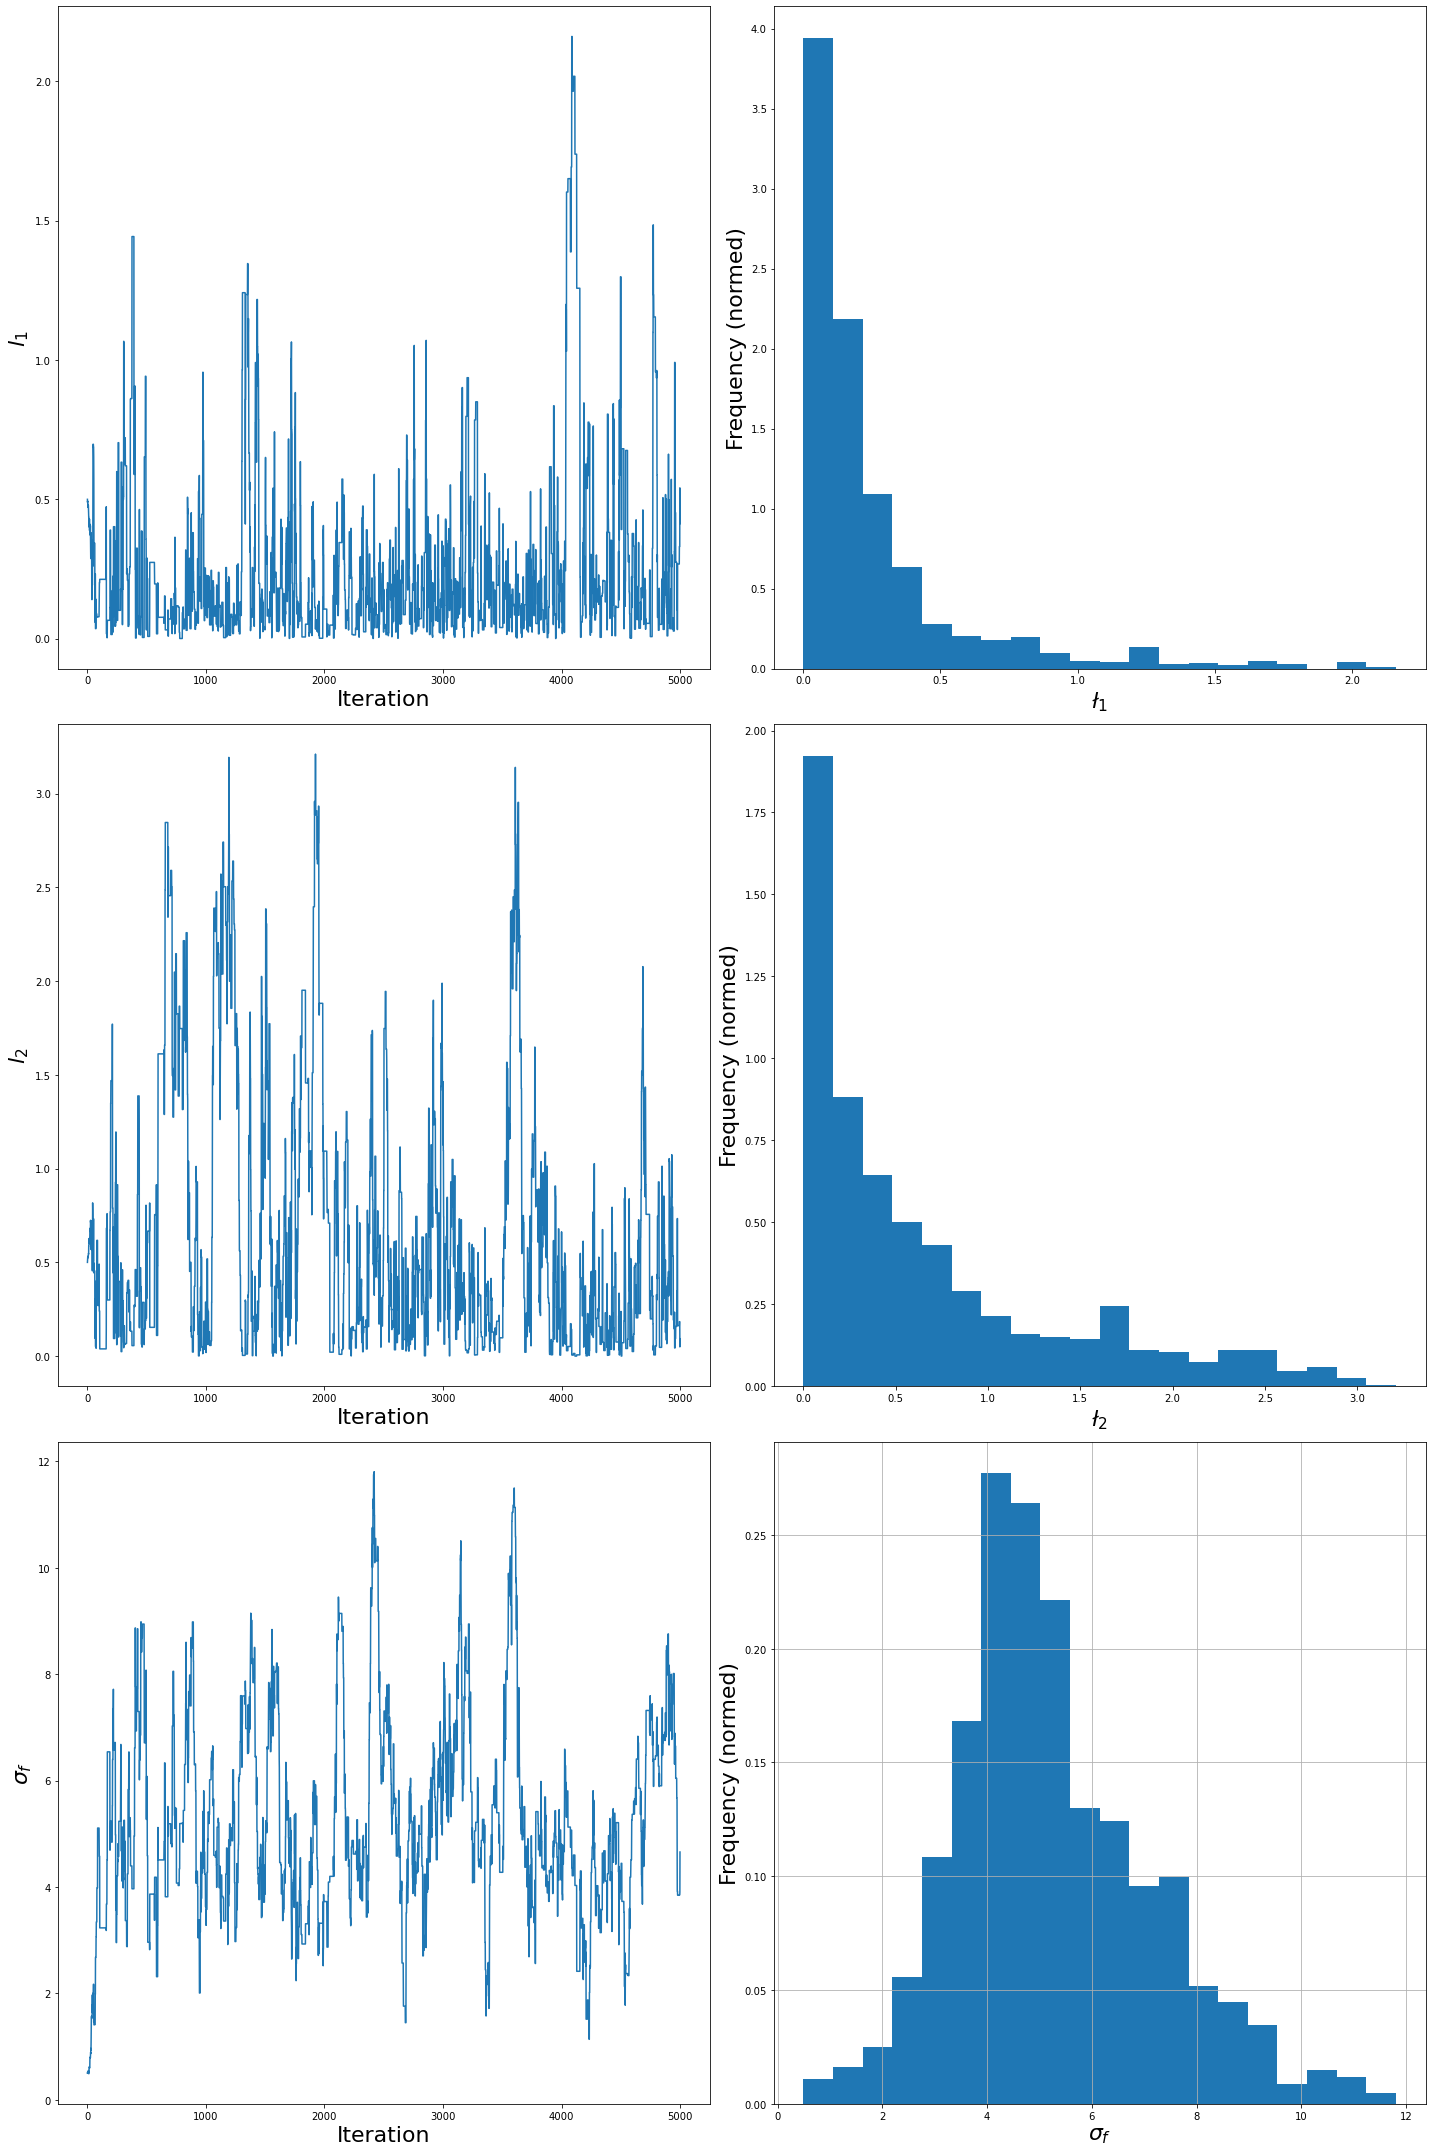

In [167]:
import matplotlib.pyplot as plt

nburn = 1.0

show=int(-nburn*samples.shape[0])
hist_show=int(-nburn*samples.shape[0])
print(show, hist_show)

fig = plt.figure(figsize=(20,30))

ax = fig.add_subplot(3,2,1)
ax.plot(samples[show:,0])
ax.set_ylabel(r"$l_1$", fontsize=22)
ax.set_xlabel("Iteration", fontsize=22)
ax = fig.add_subplot(3,2,2)
ax.hist(samples[hist_show:,0], bins=20,density=True)
ax.set_ylabel("Frequency (normed)", fontsize=22)
ax.set_xlabel(r"$\l_1$", fontsize=22)
fig.tight_layout()

ax = fig.add_subplot(3,2,3)
ax.plot(samples[show:,1])
ax.set_ylabel(r"$l_2$", fontsize=22)
ax.set_xlabel("Iteration", fontsize=22)
ax = fig.add_subplot(3,2,4)
ax.hist(samples[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)", fontsize=22)
ax.set_xlabel(r"$\l_2$", fontsize=22)
fig.tight_layout()

ax = fig.add_subplot(3,2,5)
ax.plot(samples[show:,2])
ax.set_ylabel(r"$\sigma_f$", fontsize=22)
ax.set_xlabel("Iteration", fontsize=22)
ax = fig.add_subplot(3,2,6)
ax.hist(samples[hist_show:,2], bins=20,density=True)
ax.set_ylabel("Frequency (normed)", fontsize=22)
ax.set_xlabel(r"$\sigma_f$", fontsize=22)
fig.tight_layout()


ax.grid("off")

In [179]:
import scipy.stats

# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

dist = getattr(scipy.stats, 'gamma')
# param: [a, loc, scale]
param = dist.fit(samples[show:,2])
param

(16.755535042140636, -2.3482587466422675, 0.4530530126978203)

C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  


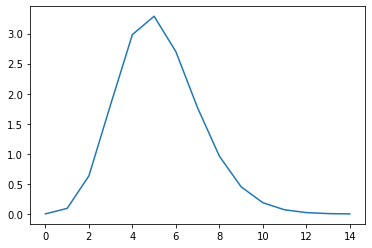

In [180]:
size = 15
x = scipy.arange(size)
pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
plt.plot(pdf_fitted, label='gamma')